<a href="https://colab.research.google.com/github/varundubey2804/Stress_Level_Prediction/blob/main/GRU_hrv_swell_all_samples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tuner
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.5 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv('/content/all-samples.csv')
df = df.dropna()


In [ ]:
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

In [ ]:
def cap_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data.apply(lambda x: np.where(x < lower_bound[x.name], lower_bound[x.name], x))
    data = data.apply(lambda x: np.where(x > upper_bound[x.name], upper_bound[x.name], x))
    return data
df = cap_outliers_iqr(df)

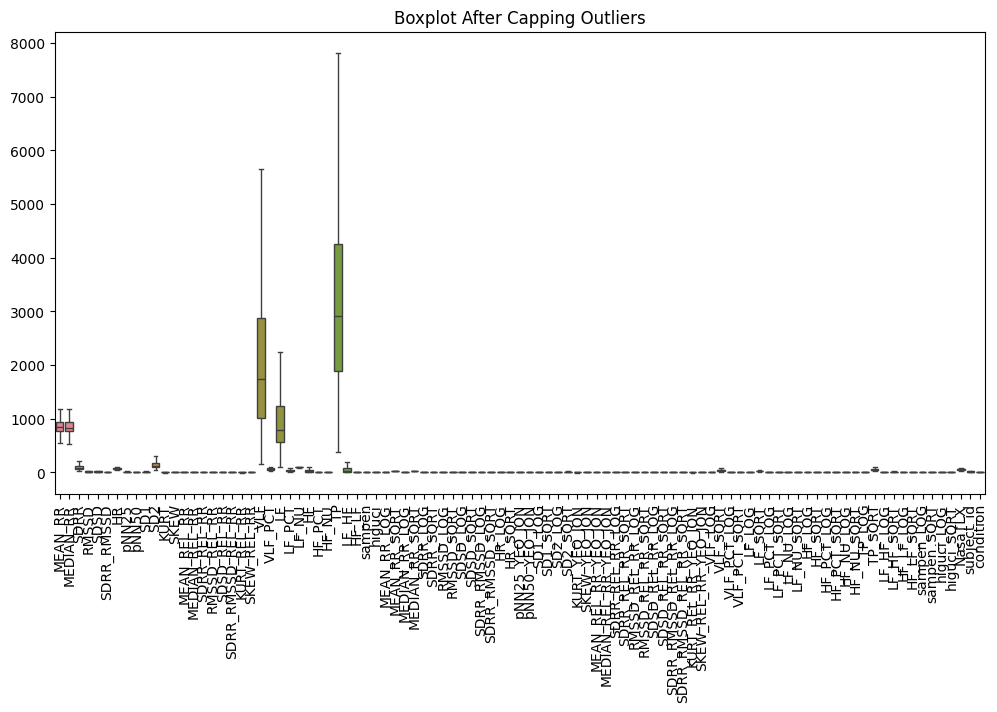

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title("Boxplot After Capping Outliers")
plt.show()

In [ ]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
y = LabelEncoder().fit_transform(y)
y = to_categorical(y)

In [ ]:
num_features_to_select = 10
selector = SelectKBest(score_func=f_classif, k=num_features_to_select)
X_new = selector.fit_transform(X, np.argmax(y, axis=1))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)


In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
def build_gru_model(hp):
    model = Sequential()
    model.add(GRU(units=hp.Int('gru_units', min_value=64, max_value=256, step=32),
                  return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(GRU(units=hp.Int('gru_units_2', min_value=32, max_value=128, step=32), return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(units=hp.Int('dense_units', min_value=16, max_value=128, step=16), activation='relu'))
    model.add(Dense(y_train.shape[1], activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.001, 0.0005, 0.0001])),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
tuner = kt.Hyperband(build_gru_model,
                     objective='val_accuracy',
                     max_epochs=30,
                     factor=3,
                     directory='gru_tuning',
                     project_name='GRU_Optimization')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
tuner.search(X_train, y_train, epochs=30, validation_data=(X_test, y_test), verbose=1)


Trial 90 Complete [00h 04m 00s]
val_accuracy: 0.7177621126174927

Best val_accuracy So Far: 0.8328405618667603
Total elapsed time: 01h 22m 55s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

In [ ]:
best_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32, verbose=1)


Epoch 1/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8791 - loss: 0.2986 - val_accuracy: 0.8792 - val_loss: 0.2956
Epoch 2/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8715 - loss: 0.3091 - val_accuracy: 0.8517 - val_loss: 0.3555
Epoch 3/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8757 - loss: 0.2954 - val_accuracy: 0.8881 - val_loss: 0.2540
Epoch 4/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8666 - loss: 0.3155 - val_accuracy: 0.8851 - val_loss: 0.2728
Epoch 5/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8739 - loss: 0.3009 - val_accuracy: 0.8799 - val_loss: 0.2855
Epoch 6/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8800 - loss: 0.2834 - val_accuracy: 0.8799 - val_loss: 0.2760
Epoch 7/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8815 - loss: 0.2893 - val_accuracy: 0.8517 - val_loss: 0.3397
Epoch 8/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8710 - loss: 0.3021 - val_accu

In [ ]:
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9030 - loss: 0.2349
Test Accuracy: 90.11%


In [ ]:
y_pred = np.argmax(best_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print("\nClassification Report:\n", classification_report(y_true, y_pred))

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.90      1490
           1       0.88      0.90      0.89      1441
           2       0.90      0.94      0.92      1466

    accuracy                           0.90      4397
   macro avg       0.90      0.90      0.90      4397
weighted avg       0.90      0.90      0.90      4397

